**Setting up the environment**

In [1]:
%%capture
files = !ls
files = [f.split("  ") for f in files][0]

isFRIQML = 'fri_qml' in files
isFRIQMLPath = isFRIQML and "setup.py" in files

# Clone the entire repo. Only run once!
if not isFRIQML:
  !git clone -l -s https://github.com/znajob/fri_qml.git fri_qml

if not isFRIQMLPath:
  %cd fri_qml

!git pull
!pip install -e .

In [2]:
# MAIN IMPORTS
import pennylane as qml
from pennylane import numpy as np
from friqml.visualisation import plot_quantum_state, plot_histogram
from friqml.utils import eps, random_state_normalized, random_state_unnormalized
from functools import partial
from tqdm.notebook import tqdm
from friqml.utils import eps

When solving the exercises refer to the [PennyLane documentation](https://pennylane.readthedocs.io/en/stable/).

Pennylane [max cut problem presentation](https://pennylane.ai/qml/demos/tutorial_qaoa_maxcut)

## Quantum aproximate optimisation algorithm

### Exercise 1
In the max cut problem we have to evolve the state with two competing Hamiltonians, $H_0=\sum_{j=1}^n\sigma^{\rm x}_j$ and $H_1=\sum_{i,j=1}^nG_{ij}(1-\sigma^{\rm z}_i\sigma^{\rm z}_j)$. Write a template `U_B` with arguments `n` and `beta` that evolves a state with the unitary $U_{\rm B}(\beta)=\exp(-i \beta H_0)$. Write also a template `U_C` that evolves a state with the unitary $U_{\rm C}(\gamma)=\exp(-i \gamma H_1)$. The template `U_C` should have one argument `graph` which is a list of edges representing pairs of connected vertices/wires.

In [3]:
# DEVICE
dev = qml.device('default.qubit', wires=4, shots=None)

In [ ]:
def U_B(beta, n):
    """Implements the unitary UB(beta) = exp(-i beta H0) where H0 = sum X_j."""
    for j in range(n):
        qml.RX(2 * beta, wires=j)

def U_C(gamma, graph):
    """Implements the unitary UC(gamma) = exp(-i gamma H1) where H1 = sum (1 - Z_i Z_j) for edges (i,j)."""
    for edge in graph:
        i, j = edge
        qml.IsingZZ(gamma, wires=[i,j])
        #qml.CNOT(wires=[i, j])
        #qml.RZ(gamma, wires=j)
        #qml.CNOT(wires=[i, j])


In [37]:
@qml.qnode(dev)
def circuit(beta,gamma,graph,n):
  U_B(beta,n)
  U_C(gamma,graph)
  return qml.state()

In [38]:
# TESTS
n = 4
beta=0.23
gamma= 1.4
graph = [(0, 1), (0, 3), (1, 2), (2, 3)]
np.allclose(np.round(circuit(beta,gamma,graph,n),8),np.array([-0.84682588-0.30107186j, -0.-0.21043723j,0.-0.21043723j, -0.04927248+0.j,0.        -0.21043723j,  0.04642563-0.0165057j , -0.04927248+0.j        ,  0.        +0.01153682j, -0.        -0.21043723j, -0.04927248+0.j        , 0.04642563-0.0165057j , -0.        +0.01153682j, -0.04927248+0.j        ,  0.        +0.01153682j, 0.        +0.01153682j, -0.0025452 -0.00090489j]))

True

### Exercise 2

Use the templates `U_B` and `U_C` to write a function `max_cut` which implements the QAOA solution to the max cut problem. The arguments of the function are `betas` (list of angles $\beta$), `gammas` (list of angles $\gamma$), `n` (number of vertices), `graph` (a list of edges (vertex pairs) defining the graph), `edge` (a pair of wires $(i,j)$ representing an edge of the graph for which the expectation $\sigma_i^{\rm z}\otimes\sigma^{\rm z}_j$ should be calculated). The function/circuit should first prepare a state $|+\rangle^{\otimes n}$ followed by alternating applications of the unitaries $U_{\rm C}(\gamma_j)$ and $U_{\rm B}(\beta_j)$. If the `edge` is `None` the circuit should return a sample, else it should return an expectation value for the specified `edge`.

In [ ]:
pauli_z_2 = np.array([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]])

def max_cut(betas, gammas, n, graph, edge=None):
    assert len(gammas) == len(
        betas), 'Betas and gammas should have equal length.'
    # apply Hadamards to get the n qubit |+> state
    for wire in range(n):
        qml.Hadamard(wires=wire)
    # p instances of unitary operators
    n_layers = len(gammas)
    for i in range(n_layers):
        U_C(gammas[i], graph)
        U_B(betas[i], n)
    if edge is None:
        # measurement phase
        return qml.sample()
    # during the optimization phase we are evaluating a term
    # in the objective using expval
    [i,j] = edge
    return qml.expval(qml.PauliZ(i) @ qml.PauliZ(j))


In [52]:
dev_sample = qml.device('default.qubit', wires=4, shots=1)
dev_exact = qml.device('default.qubit', wires=4, shots=None)

circuit_sample = qml.qnode(dev_sample)(max_cut)
circuit_exact = qml.qnode(dev_exact)(max_cut)

In [53]:
# TESTS
# Basis test
betas = [1.4,2.2,0.31]
gammas = [0.4,1.2,2.1]
print(np.isclose(circuit_exact(betas,gammas,n,graph,[0,1]),-0.565547665503964))
print(len(circuit_sample(betas,gammas,n,graph,None))==4)

True
True


### Exercise 3

Finally, we optimize the `max_cut` circuit. Complete the function `qaoa_maxcut`. The function should:
1.   Create a random initial guess for `betas` and `gammas` and store it in a variable `params`
2.   Create/define a function `objective` that calculates the objective function for the max cut problem for a given graph. The argument of the function is `params` which is a list containing the lists `betas` and `gammas`.
3.   Define the optimiser
4.   Optimize for 30 steps
5.   Calculate 100 samples from the `max_cut` circuit and convert the samples to integers (use the provided function `bitstring_to_int`)
6.   Return the objective for the current parameter values and the samples



In [54]:
# DEVICE
dev = qml.device('default.qubit', wires=4, shots=1)

In [55]:
# SOLUTION
from friqml.solutions.phase_estimation import ipowers_of_unitary ,iqpe

??

In [ ]:
def bitstring_to_int(bit_string_sample):
    bit_string = "".join(str(bs) for bs in bit_string_sample)
    return int(bit_string, base=2)

def qaoa_maxcut(n_layers, graph, n):
    print("\np={:d}".format(n_layers))

    # initialize the parameters near zero
    init_params = 0.01 * np.random.rand(2, n_layers, requires_grad=True)

    # minimize the negative of the objective function
    def objective(params):
        betas = params[0]
        gammas = params[1]
        neg_obj = 0
        for edge in graph:
            # objective for the MaxCut problem
            neg_obj -= 0.5 * \
                (1 - circuit_sample(betas, gammas, n, graph, edge=edge))
        return neg_obj

    # initialize optimizer: Adagrad works well empirically
    opt = qml.AdagradOptimizer(stepsize=0.5)

    # optimize parameters in objective
    params = init_params
    steps = 30
    for i in range(steps):
        params = opt.step(objective, params)
        if (i + 1) % 5 == 0:
            print("Objective after step {:5d}: {: .7f}".format(
                i + 1, -objective(params)))

    # sample measured bitstrings 100 times
    bit_strings = []
    n_samples = 100
    for i in range(0, n_samples):
        bit_strings.append(bitstring_to_int(circuit_sample(
            params[0], params[1], n, graph, edge=None)))

    return -objective(params), bit_strings


# perform qaoa on our graph with p=1,2 and

In [ ]:
# keep the bitstring sample lists
bitstrings1 = qaoa_maxcut(1,graph,4)[1]
bitstrings2 = qaoa_maxcut(2,graph,4)[1]

NameError: name 'bitstrings1' is not defined

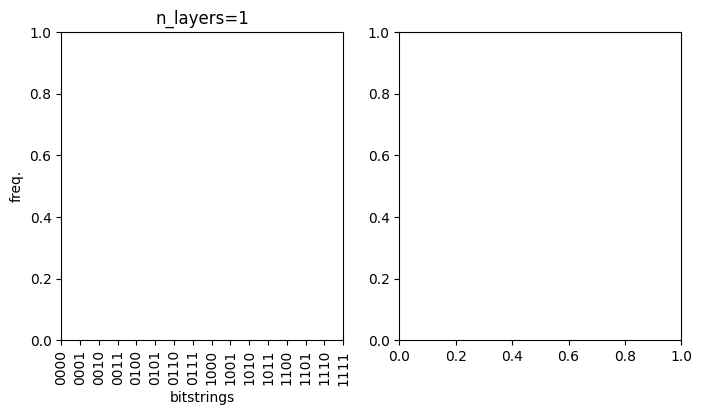

In [57]:
import matplotlib.pyplot as plt

xticks = range(0, 16)
xtick_labels = list(map(lambda x: format(x, "04b"), xticks))
bins = np.arange(0, 17) - 0.5

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.title("n_layers=1")
plt.xlabel("bitstrings")
plt.ylabel("freq.")
plt.xticks(xticks, xtick_labels, rotation="vertical")
plt.hist(bitstrings1, bins=bins)
plt.subplot(1, 2, 2)
plt.title("n_layers=2")
plt.xlabel("bitstrings")
plt.ylabel("freq.")
plt.xticks(xticks, xtick_labels, rotation="vertical")
plt.hist(bitstrings2, bins=bins)
plt.tight_layout()
plt.show()